In [3]:
import os
import sys
import requests

import mercury
from dotenv import load_dotenv

import networkx as nx
from netgraph import Graph, InteractiveGraph
from ipysigma import Sigma
from pyvis.network import Network

import pandas as pd
from pandas import json_normalize

import matplotlib
import matplotlib.pyplot as plt

import itertools

import xmltodict

In [4]:
# Load app for json display
mercury.App(title="Display JSON", static_notebook=True)

# Load server environment
load_dotenv(os.path.dirname(sys.path[1]) + '/server/.env')

mercury.App

True

# 🗄️ Data

In [5]:
# API search info
OPENALEX_API_URL = os.environ.get('OPENALEX_API_URL')

## Structure

Get single entry

In [6]:
# Request answer
json_answer = requests.get(OPENALEX_API_URL).json()

Display answer

In [7]:
# Display json
mercury.JSON(json_answer)

## Requests

Search by keywords

In [208]:
def url_thematic(url:str, thematic:list[str], cursor:str='', per_page:int=100) -> str:
    """
    This function create the URL string with the theme of the query and the cursor
    to get all the available pages on OpenAlex
    :param thematic: theme(s) you are interested in
    :return: URL string
    """
    if thematic:
        thematic = ' AND '.join(thematic)
        url = url+',' if url[-1] != ',' else url
        url += f"title.search:{thematic},abstract.search:{thematic}&mailto=bso@recherche.gouv.fr&cursor={cursor}*&per_page={per_page}"

    return url

In [210]:
# Keywords list (AND)
keywords = ['video games', 'artificial intelligence']

# Search url
request_url = url_thematic(OPENALEX_API_URL, keywords, per_page=7)
print(request_url)

# Request answer
json_answer = requests.get(request_url).json()

https://api.openalex.org/works?filter=publication_year:2018-,title.search:video games AND artificial intelligence,abstract.search:video games AND artificial intelligence&mailto=bso@recherche.gouv.fr&cursor=*&per_page=7


Display answer

In [211]:
# Display json
mercury.JSON(json_answer)

In [213]:
# Keywords list (AND)
keywords = ['video games', 'artificial intelligence']

# Search url
request_url = url_thematic(OPENALEX_API_URL, keywords, per_page=7)
print(request_url)

# Request answer
json_answer2 = requests.get(request_url).json()

mercury.JSON(json_answer2)

https://api.openalex.org/works?filter=publication_year:2018-,title.search:video games AND artificial intelligence,abstract.search:video games AND artificial intelligence&mailto=bso@recherche.gouv.fr&cursor=IlswLjAsIDE2ODc5MTA0MDAwMDAsICdodHRwczovL29wZW5hbGV4Lm9yZy9XNDM3OTY0NTg2MyddIg==*&per_page=7


Search by orcid

In [11]:
def url_orcid(url:str, orcids:list[str], per_page:int=100) -> str:
    """
    This function create the URL string with the orcid of authors and the cursor
    to get all the available pages on OpenAlex
    :param orcids: author(s) (orcid) you are interested in
    :return: URL string
    """
    if orcids:
        orcids = ' AND '.join(orcids)
        url = url+',' if url[-1] != ',' else url
        url += f"author.orcid:{orcids}&mailto=bso@recherche.gouv.fr&cursor=*&per_page={per_page}"

    return url

In [193]:
# author id list
orcids = ["0000-0003-2197-515X"]

# Search url
request_url = url_orcid(OPENALEX_API_URL, orcids)
print(request_url)

# Request answer
json_answer = requests.get(request_url).json()

https://api.openalex.org/works?filter=publication_year:2018-,author.orcid:0000-0003-2197-515X&mailto=bso@recherche.gouv.fr&cursor=*&per_page=100


Display answer

In [194]:
# Display json
mercury.JSON(json_answer)

In [27]:
def idref_json_get(idref:str) -> dict:
    """Use idref api to get author json info

    Args:
        idref: author idref

    Returns:
        author json data
    """
    idref_url = f'https://www.idref.fr/{idref}.xml'
    idref_xml = requests.get(idref_url).text
    idref_json = xmltodict.parse(idref_xml, attr_prefix='')
    return idref_json


def idref_json_find_orcid(idref_json:dict) -> str:
    """This function check author idref data and try to find an ORCID.
    Returns None if no ORCID found.

    Args:
        idref_json: author json data

    Returns:
        ORCID
    """
    orcid = None
    found = False
    idref_data = idref_json.get('record').get('datafield')

    for subid in range(len(idref_data)):
        subfield = idref_data[subid].get('subfield')
    
        if not isinstance(subfield, list):
            continue

        for elem in subfield:
            if isinstance(elem, dict):
                elem = elem.get('#text') # if xml parser
            if elem == 'ORCID':
                found = True
                break

        if found:
            for elem in subfield:
                if isinstance(elem, dict):
                    elem = elem.get('#text') # if xml parser
                if type(elem) is str and len(elem) == 19: # @todo: check format better
                    orcid = elem
                    break

        if orcid:
            break

    return orcid

In [32]:
idref = '185650074'
orcid = idref_json_find_orcid(idref_json_get(idref))
if orcid is not None:
    print(f"idref{idref}: orcid found -> {orcid}")

idref185650074: orcid found -> 0000-0003-2197-515X


# 🌐 Network

## Creation

Clean answer and create graph

In [33]:
mercury.JSON(json_answer)

In [133]:
def url_last_segment(url:str) -> str:
    """Remove last segment of an url
        example : http://ww.test.com/TEST1 
        --> returns TEST1
    """

    if not url:
        return None

    for split in reversed(url.rsplit('/')):
        if split:
            return split
    
    return None

In [186]:
max_coauthors=20

# Init arrays
nb_pub_removed = 0
authors_data = {}
authors_names = {}
wikidata_names = {}

# print("Number of works : " + str(len(json_answer.get("results"))))

# Filter data
# 1. Loop over works
for work in json_answer.get("results"):
    work_id = url_last_segment(work.get("id"))
    authorships = work.get("authorships")

    # 2. Loop over authors and remove publication if too many coauthors
    if len(authorships) > max_coauthors:
        print(f"{work.get('id')}: removing publication ({len(authorships)} authors)")
        nb_pub_removed += 1
        continue

    # 3. Get author information
    for authorship in authorships:
        author = authorship.get("author")
        author_id = url_last_segment(author.get("id"))
        author_orcid = url_last_segment(author.get("orcid"))
        author_name = author.get("display_name")
        authors_names.setdefault(author_id, author_name)

        # Add author
        author_data = {"name": author_name, "orcid": author_orcid}
        authors_data.setdefault(author_id, {'work_count':0, 'work_id':[], 'coauthors':{}, 'wikidata':{}}).update(author_data)
        authors_data.get(author_id)['work_count'] += 1
        authors_data.get(author_id)['work_id'].append(work_id)
        
        # print(f"{author_name}: number of coauthors = {len(authorships) - 1}")

        # 4. Add coauthors information
        for coauthorship in authorships:
            coauthor = coauthorship.get("author")
            coauthor_id = url_last_segment(coauthor.get("id"))
            coauthor_name = coauthor.get("display_name")
            if coauthor_id != author_id:
                authors_data.get(author_id).get("coauthors").setdefault(coauthor_id, 0)
                authors_data.get(author_id).get("coauthors")[coauthor_id] += 1

        # 5. Get wikidata topics information
        for concept in work.get("concepts"):
            wikidata = url_last_segment(concept.get("wikidata"))
            wikidata_names.setdefault(wikidata, concept.get("display_name"))
            authors_data.get(author_id).get("wikidata").setdefault(wikidata, 0)
            authors_data.get(author_id).get("wikidata")[wikidata] += 1

mercury.JSON(authors_data)

In [188]:
min_works = 1

# Init array
nb_aut_removed = []

# Create graph
G = nx.Graph()

# 1. Loop over all authors 
for author in authors_data.values():

    # 2. Filter number of works
    if author.get("work_count") < min_works:
        nb_aut_removed += 1
        continue

    # 3. Add node 
    G.add_node(author.get("name"), size=author.get("work_count"))

    # 4. Add edges
    for coauthor, cowork_count in author.get("coauthors").items():
        G.add_edge(author.get("name"), authors_names.get(coauthor), weight = cowork_count)
    

In [ ]:
# # Group by id
# grouped_df = authors_df.groupby("id").agg(
#     name = pd.NamedAgg(column="name", aggfunc="first"),
#     work_count = pd.NamedAgg(column="work", aggfunc="count"),
#     coauthors = pd.NamedAgg(column="coauthors", aggfunc="sum"),
#     topics = pd.NamedAgg(column="topics", aggfunc="sum")
# )

# display(grouped_df)

# 👥 Communities

## Structure

* Communities = lists of nodes

## Models

* Louvain
* Girvan-Newman
* CPM
* BigClam
* Graph Neural Network

## Creation

Use Louvain algorithm (networkx)

In [189]:
# Networkx louvain algo
lv_communities = nx.community.louvain_communities(G, seed=42)
lv_dict = {n:c for c in range(len(lv_communities)) for n in lv_communities[c]}

# Add communities to graph element
# for n in G.nodes():
#     G.nodes[n]['label'] = lv_dict.get(n)

print("Number of communities found :", len(lv_communities))

Number of communities found : 2


Use Girvan-Newman algorithm (networkx)

In [75]:
# Networkx girvan newman algo
# k = 15
# limited = itertools.takewhile(lambda c: len(c) <= k, nx.community.girvan_newman(G))
# for communities in limited:
#     print(communities)
#     gn_communities = tuple(sorted(c) for c in communities)




communities = list(nx.community.girvan_newman(G))
modularities = [nx.community.modularity(G, communities[k]) for k in range(len(communities))]
max_modularity = max(modularities)
max_modularity_idx = modularities.index(max_modularity)

print(f"Best modularity : {max_modularity} (k={max_modularity_idx+1})")

gn_communities = communities[max_modularity_idx]
gn_dict = {n:c for c in range(len(gn_communities)) for n in gn_communities[c]}

print("Number of communities found :", len(gn_communities))

Best modularity : 0.7351910399027359 (k=6)
Number of communities found : 19


Use k-clique (CPM) algorithm (networkx)

In [69]:
# Networkx k clique algo
cliques = list(nx.community.k_clique_communities(G, 3))
kc_communities = [list(c) for c in cliques]
kc_dict = {n:c for c in range(len(kc_communities)) for n in kc_communities[c]}

print("Number of communities found :", len(kc_communities))

Number of communities found : 5


## Analysis

Communities best topics

In [40]:
# Store all communities topics
communities_topics = {}
for author, community in lv_dict.items():
    if community not in communities_topics:
        communities_topics[community] = {'topics': {}}
    for topic, weight in all_edges[author]['topics'].items():
        if topic not in communities_topics[community]['topics']:
            communities_topics[community]['topics'][topic] = 0
        communities_topics[community]['topics'][topic] += weight

In [41]:
# Get top 5 topics for each community
for c in range(len(communities_topics)):
    topics = communities_topics[c]['topics']
    top = sorted(topics, key=topics.get, reverse=True)[:5]
    print(f"Community {c} :")
    print(top, '\n')

Community 0 :
['jeux vidéos', 'jeux vidéo', 'langage politique', 'presse politique', 'hommes politiques'] 

Community 1 :
['jeux vidéos', 'jeux vidéo', 'interaction homme-ordinateur', 'traduction', 'joueurs de jeux vidéo'] 

Community 2 :
['anthropomorphisme', 'réalité virtuelle', 'socialisation', 'jeux vidéo', 'jeux vidéos'] 

Community 3 :
['jeux vidéos', 'jeux vidéo', 'transmédia', 'horreur', 'genre'] 

Community 4 :
['jeux vidéos', 'sujet (psychologie)', 'symbolisme -- aspect psychologique', 'psychopathologie transgénérationnelle', 'mutisme électif'] 

Community 5 :
['jeux vidéos', 'performance artistique', 'espace public', 'video games', 'sound design'] 

Community 6 :
['jeux vidéos', 'avatar', 'assassin’s creed', 'ordinateur', 'stéréotypes de genre'] 

Community 7 :
['mythes nordiques', 'intermédialité', 'assassin’s creed valhalla', 'franchise', 'transmédia'] 

Community 8 :
['antiquité', 'jeux vidéos', 'gameplay', 'rome', 'unités militaires'] 

Community 9 :
['jeux vidéos', 'int

# 🖼️ Visualisation

## Matplotlib

Display network

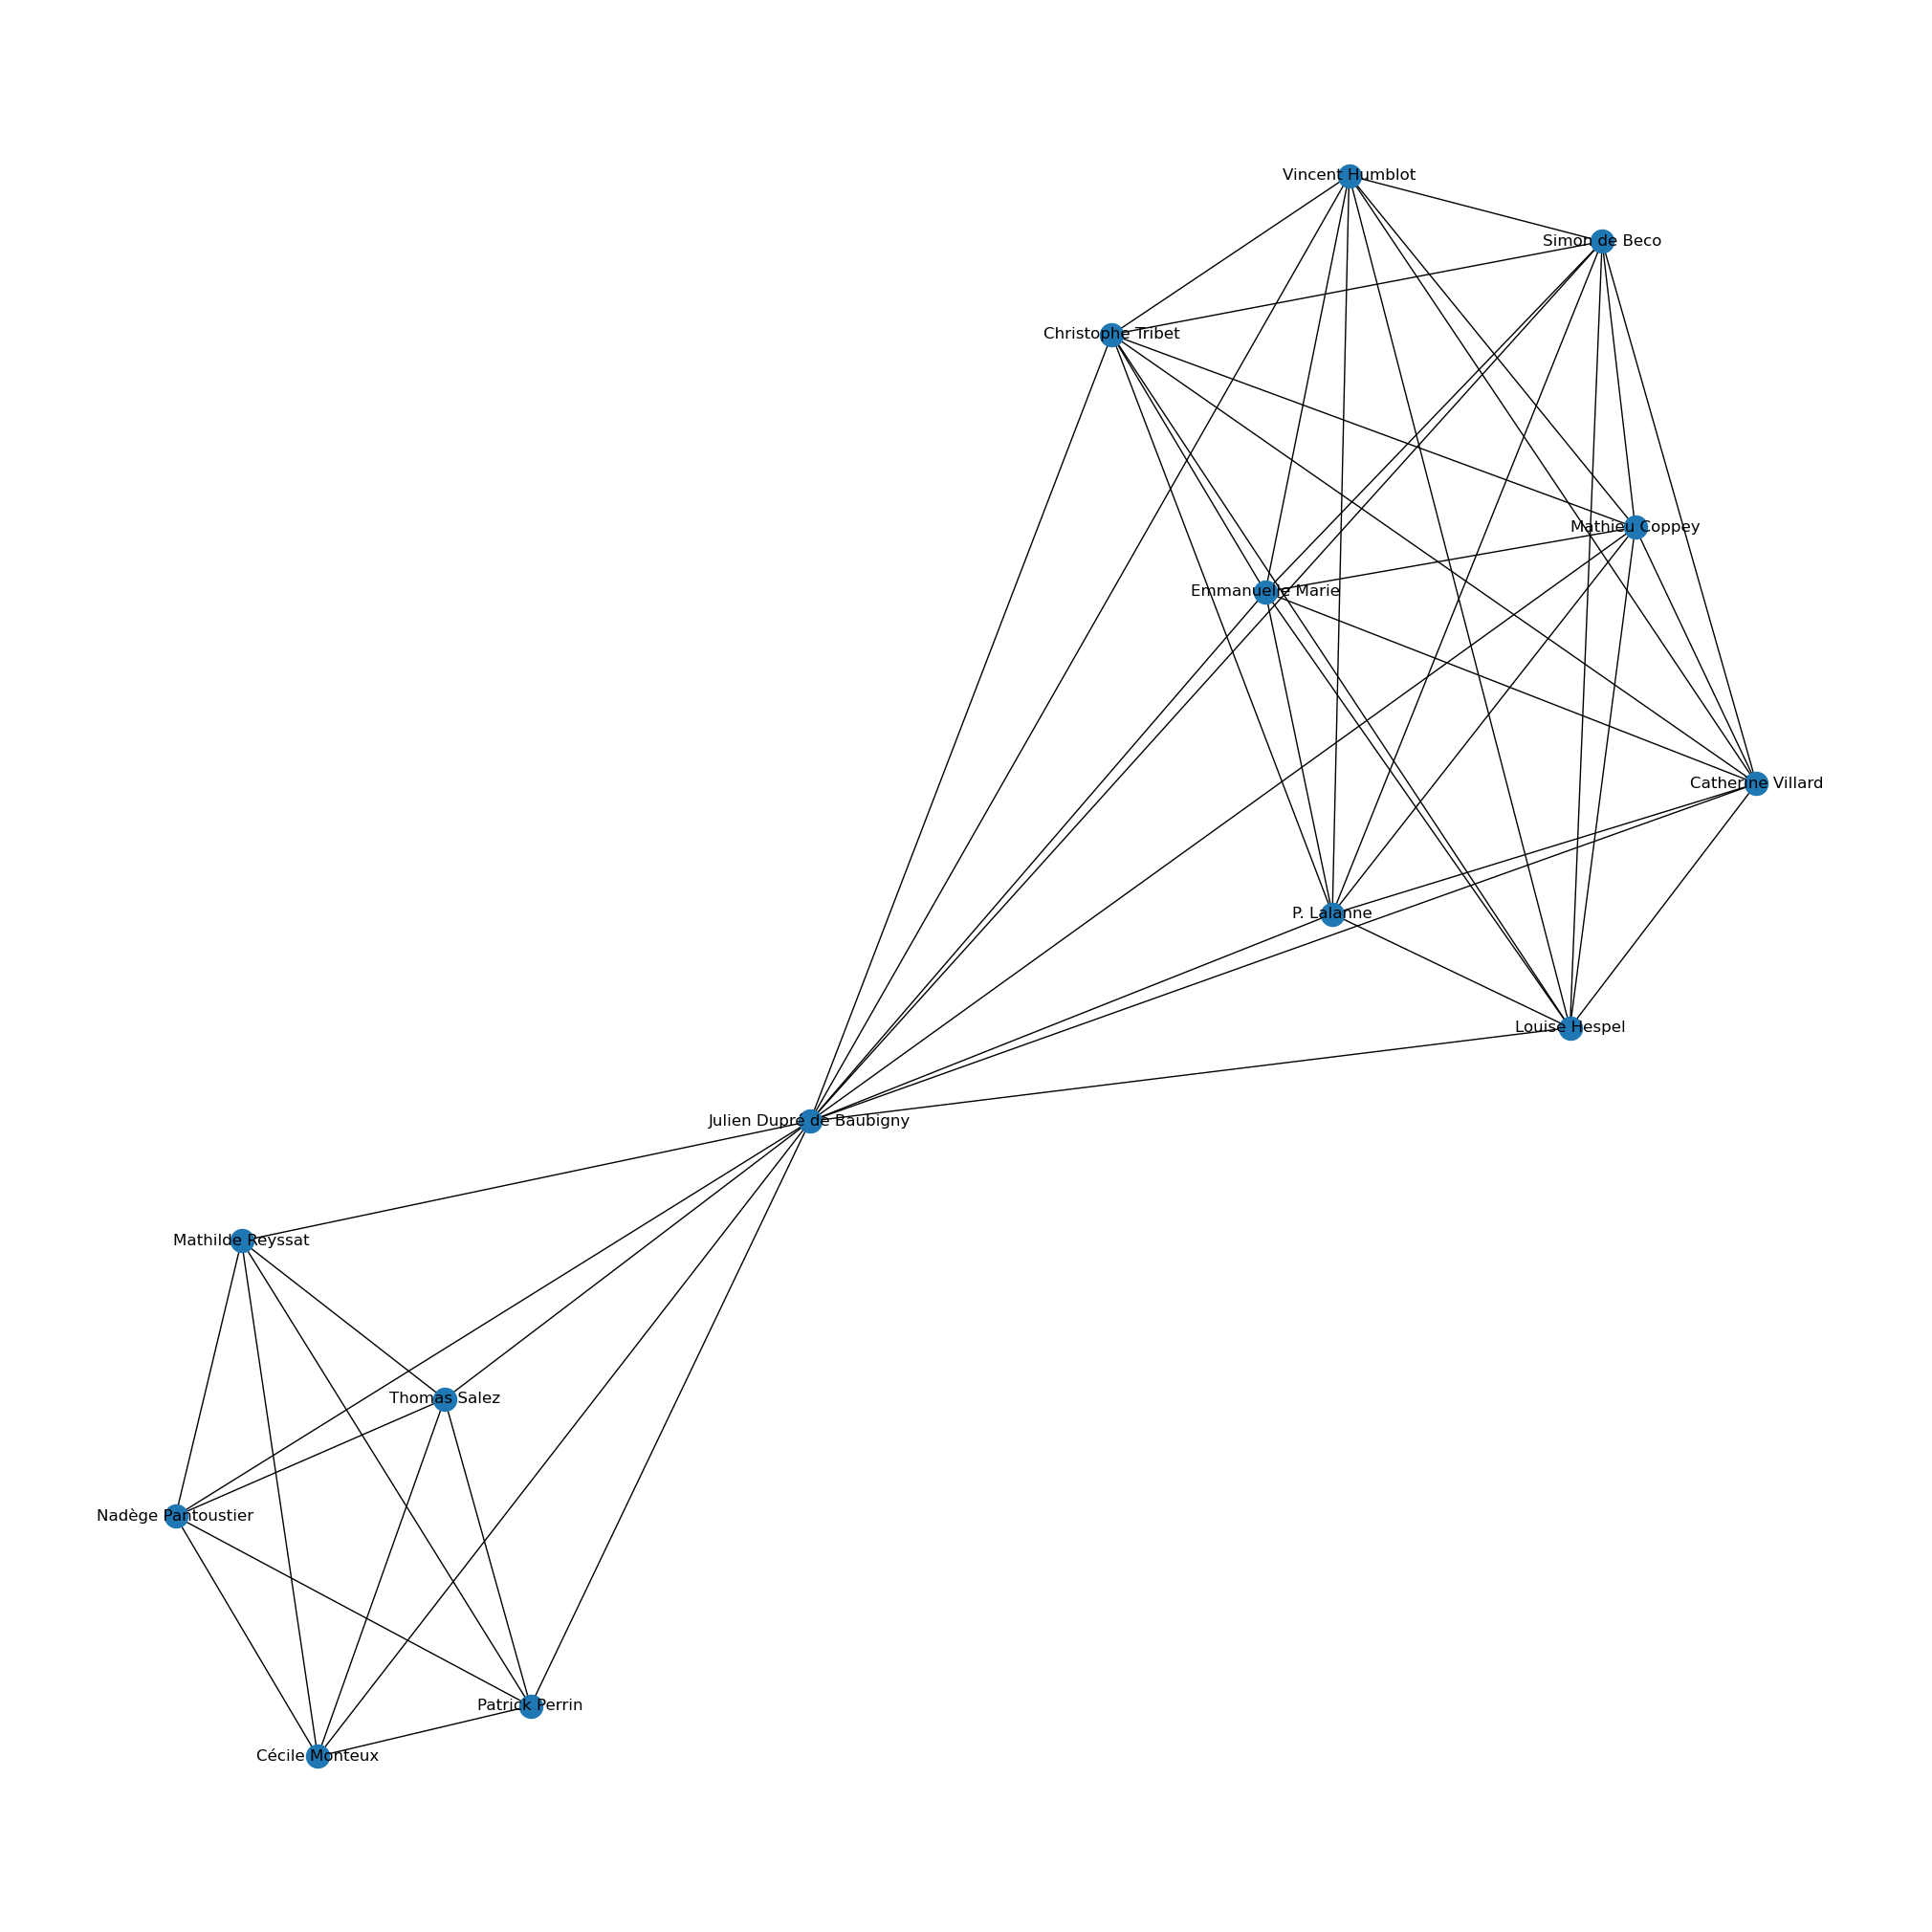

In [215]:
# Draw network
plt.figure(figsize=(20,20))
nx.draw(G, pos=nx.spring_layout(G), with_labels = True)
plt.draw()

Display Louvain communities

In [ ]:
# Color communities
cmap = matplotlib.colormaps['turbo'].resampled(len(lv_communities))

# Draw network
plt.figure(figsize=(20, 20))
pos = nx.spring_layout(G)
nx.draw_networkx(G, pos, cmap=cmap, nodelist=lv_dict.keys(), node_color=list(lv_dict.values()))
plt.axis('off')
plt.draw()

Display Girvan-Newman communities

In [ ]:
# Color communities
cmap = matplotlib.colormaps['turbo'].resampled(len(gn_communities))

# Draw network
plt.figure(figsize=(20, 20))
pos = nx.spring_layout(G)
nx.draw_networkx(G, pos, cmap=cmap, nodelist=gn_dict.keys(), node_color=list(gn_dict.values()))
plt.axis('off')
plt.draw()

Display k-clique communities

In [ ]:
# Color communities
cmap = matplotlib.colormaps['turbo'].resampled(len(kc_communities))

# Draw network
plt.figure(figsize=(20, 20))
pos = nx.spring_layout(G)
nx.draw_networkx(G, pos, cmap=cmap, nodelist=kc_dict.keys(), node_color=list(kc_dict.values()))
plt.axis('off')
plt.draw()

## Netgraph

Display network

In [ ]:
# Draw non interactive network
Graph(G, node_layout='spring')
plt.show()

Display Louvain communities

In [ ]:
# Color communities
cmap = matplotlib.colormaps['turbo'].resampled(len(lv_communities))
community_to_color = {c: list(cmap(c)) for c in range(len(lv_communities))}
node_color = {n: community_to_color[c] for n, c in lv_dict.items()}


# Draw non interactive communities
Graph(G, node_color=node_color, node_layout='community', 
      node_layout_kwargs=dict(node_to_community=lv_dict)
)

Display Girvan-Newman communities

In [ ]:
# Color communities
cmap = matplotlib.colormaps['turbo'].resampled(len(gn_communities))
community_to_color = {c: list(cmap(c)) for c in range(len(gn_communities))}
node_color = {n: community_to_color[c] for n, c in gn_dict.items()}


# Draw non interactive communities
Graph(G, node_color=node_color, node_layout='community', 
      node_layout_kwargs=dict(node_to_community=gn_dict)
)

## Pyvis

Write pyvis html file

In [ ]:
# Color communities
cmap = matplotlib.colormaps['turbo'].resampled(len(lv_communities))
community_to_color = {c: list(cmap(c)) for c in range(len(lv_communities))}
# node_color = {n:c for n, c in lv_dict.items()}
nx.set_node_attributes(G, lv_dict, 'group')

# Pyvis network
net = Network()
net.toggle_physics(False)
net.from_nx(G)
net.write_html('nx2.html')

## Sigma.js

Display network

In [ ]:
# Use sigma widget
Sigma(G, node_size=G.degree, node_color='category')

Display Louvain communities

In [ ]:
# Color communities
cmap = matplotlib.colormaps['turbo'].resampled(len(lv_communities))
community_to_color = {c: list(cmap(c)) for c in range(len(lv_communities))}
node_color = {n:c for n, c in lv_dict.items()}

# Sigma visualization
Sigma(G, node_size=G.degree, node_color=node_color)

Display Girvan-Newman communities

In [ ]:
# Color communities
cmap = matplotlib.colormaps['turbo'].resampled(len(gn_communities))
community_to_color = {c: list(cmap(c)) for c in range(len(gn_communities))}
node_color = {n:c for n, c in gn_dict.items()}

# Sigma visualization
Sigma(G, node_size=G.degree, node_color=node_color)

Display k-clique communities

In [ ]:
# Color communities
cmap = matplotlib.colormaps['turbo'].resampled(len(kc_communities))
community_to_color = {c: list(cmap(c)) for c in range(len(kc_communities))}
node_color = {n:c for n, c in kc_dict.items()}

# Sigma visualization
Sigma(G, node_size=G.degree, node_color=node_color)